# Imports

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import statistics
import xgboost as xgb
import re

# Functions

In [29]:
def generate_rmse(y_pred: np.array, y_true: np.array) -> float:
    """
    Compute the RMSE from y_pred and y_true.

    Args:
        y_pred: numpy array, the predicted target values
        y_true: numpy array, the true target values

    Returns:
        rmse: float, the root mean squared error of y_pred and y_true
    """

    error = y_pred - y_true
    mse = (error**2).mean()
    rmse = np.sqrt(mse)

    return rmse

In [98]:
def parse_xgb_output(output):
    
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

# Dataset loading

In [2]:
data = pd.read_csv('housing.csv')

In [3]:
data.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Dataset preparation

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [7]:
# keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
data = data[data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [8]:
# Fill missing values with zeros
data= data.fillna(0)

In [9]:
# Apply the log transform to median_house_value
data['median_house_value'] = np.log1p(data['median_house_value'])

In [16]:
# Do train/validation/test split with 60%/20%/20% distribution.
full_train, test = train_test_split(data, test_size=0.2, random_state=1)

In [17]:
# Get train and validation datasets
train, val = train_test_split(full_train, test_size = 0.25, random_state=1)

In [18]:
# Isolate y_value
y_train = train['median_house_value']
y_val = val['median_house_value']
y_test = test['median_house_value']

In [19]:
# Remove this column of features
del train['median_house_value']
del val['median_house_value']
del test['median_house_value']

In [20]:
# Create dv to turn the dataframes into matrices, fit on the training dataset:

# Create dictionaries from input dataframes obtained after splitting the data
train_dicts = train.to_dict(orient="records")
val_dicts = val.to_dict(orient="records")
test_dicts = test.to_dict(orient="records")

# Initiate the DictVectorizer and fit it on the train data dictionary
dv = DictVectorizer(sparse=True)
dv.fit(train_dicts)

# Obtain the transformed features using the fitted DictVectorizer
train_dv = dv.transform(train_dicts)
val_dv = dv.transform(val_dicts)
test_dv = dv.transform(test_dicts)

# Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

- Train a model with max_depth=1.
- Which feature is used for splitting the data?
    - ocean_proximity
    - total_rooms
    - latitude
    - population

In [24]:
decision_tree_regressor = DecisionTreeRegressor(max_depth=1)
decision_tree_regressor.fit(train_dv, y_train)

DecisionTreeRegressor(max_depth=1)

In [25]:
print(export_text(decision_tree_regressor, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



The feature used to split the data is ocean_proximity.

# Question 2

Train a random forest model with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)


- What's the RMSE of this model on validation?

    - 0.045
    - 0.245
    - 0.545
    - 0.845

In [27]:
random_forest = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [28]:
random_forest.fit(train_dv, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [30]:
y_pred_val = random_forest.predict(val_dv)

In [33]:
round(generate_rmse(y_pred_val, y_val),3)

0.245

The obtained RMSE on the validation dataset after training a random forest regressor model is equal to 0.245.

# Question 3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160

In [36]:
scores = []

In [43]:
for n in tqdm(range(10,201,10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(train_dv, y_train)
    
    y_pred_val = rf.predict(val_dv)
    rmse = generate_rmse(y_pred_val, y_val)
    scores.append((n,rmse))

  0%|          | 0/20 [00:00<?, ?it/s]

In [44]:
df_scores = pd.DataFrame(scores, columns=["n_estimators",'RMSE'])

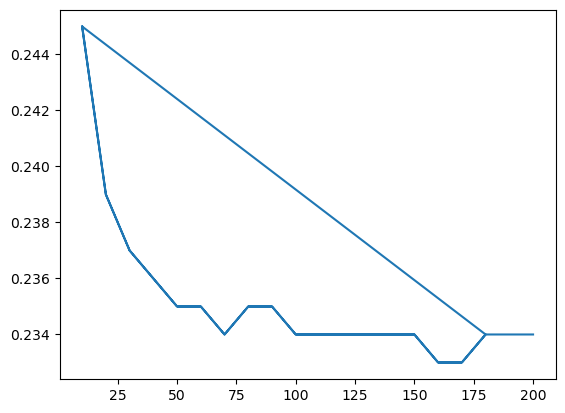

In [48]:
plt.plot(df_scores.n_estimators, df_scores.RMSE.round(3))
plt.show()

The RMSE value decreases until around n_estimators = 160.

# Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values:
    - try different values of n_estimators from 10 till 200 (with step 10)
    - calculate the mean RMSE
    - Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

- 10
- 15
- 20
- 25

In [56]:
scores = []

In [57]:
for max_depth in tqdm([10, 15, 20, 25]):
    
    rmse_list = []
    
    for n_estimators in tqdm(range(10,201,10)):
        
        rf = RandomForestRegressor(n_estimators=n_estimators, 
                                   max_depth=max_depth,
                                   random_state=1,
                                   n_jobs=-1)
        
        rf.fit(train_dv, y_train)

        y_pred_val = rf.predict(val_dv)
        rmse = generate_rmse(y_pred_val, y_val)
        rmse_list.append(rmse)
    
    mean_rmse = statistics.mean(rmse_list)
    scores.append((max_depth,mean_rmse))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [58]:
df_scores = pd.DataFrame(scores, columns=["max_depth",'mean_rmse'])

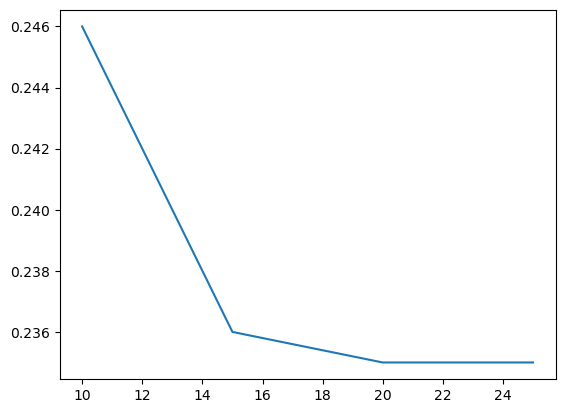

In [59]:
plt.plot(df_scores.max_depth, df_scores.mean_rmse.round(3))
plt.show()

The best max_depth using the mean RMSE is equal to: 20.

# Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parameters:
    - n_estimators=10,
    - max_depth=20,
    - random_state=1,
    - n_jobs=-1 (optional)

- Get the feature importance information from this model

What's the most important feature (among these 4)?

- total_rooms
- median_income
- total_bedrooms
- longitude

In [60]:
random_forest = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1, max_depth=20)

In [61]:
random_forest.fit(train_dv, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [62]:
# Feature importance
random_forest.feature_importances_

array([0.0151361 , 0.03031726, 0.10200703, 0.08624381, 0.33561113,
       0.29247297, 0.07380644, 0.02713606, 0.01585222, 0.02141699])

In [64]:
# Feature names
dv.feature_names_

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [67]:
dict_feature_importance = zip(dv.feature_names_, random_forest.feature_importances_)

In [68]:
feature_importance_df = pd.DataFrame(dict_feature_importance, columns=["Feature", "Importance"])

In [70]:
feature_importance_df[feature_importance_df["Importance"] == feature_importance_df["Importance"].max()]

,Feature,Importance
4,median_income,0.335611


The median_income feature has the most importance in this model.

# Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```python
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both give equal value

In [71]:
# Install xgboost
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
    --------------------------------------- 1.8/99.7 MB 37.7 MB/s eta 0:00:03
   - -------------------------------------- 3.2/99.7 MB 33.8 MB/s eta 0:00:03
   - -------------------------------------- 4.4/99.7 MB 35.3 MB/s eta 0:00:03
   -- ------------------------------------- 6.0/99.7 MB 31.9 MB/s eta 0:00:03
   --- ------------------------------------ 7.5/99.7 MB 34.3 MB/s eta 0:00:03
   --- ------------------------------------ 8.9/99.7 MB 31.5 MB/s eta 0:00:03
   ---- ----------------------------------- 10.5/99.7 MB 32.8 MB/s eta 0:00:03
   ---- ----------------------------------- 12.0/99.7 MB 31.2 MB/s eta 0:00:03
   ----- ---------------------------------- 14.0/99.7 MB 32.7 MB/s eta 0:00:03
   ------ ----------

In [83]:
# Create DMatrix for train and validation
features = dv.feature_names_

In [88]:
# Avoid the "ValueError: feature_names must be string, and may not contain [, ] or <" error
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

In [89]:
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=_1H OCEAN',
 'ocean_proximity=INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [90]:
dtrain = xgb.DMatrix(train_dv, label = y_train, feature_names=features)

In [91]:
dval = xgb.DMatrix(val_dv, label = y_val, feature_names=features)

In [92]:
# Create a watchlist
watchlist = [(dtrain,'train'), (dval, 'val')]

In [107]:
%%capture output

# Set XGB parameters and train the model
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [108]:
df_score_3 = parse_xgb_output(output)

In [109]:
%%capture output

# Set XGB parameters and train the model
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [110]:
df_score_1 = parse_xgb_output(output)

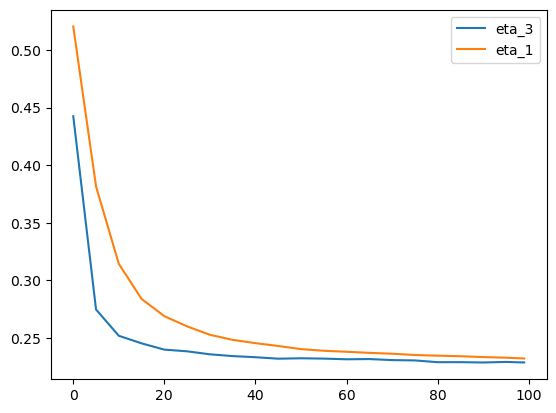

In [111]:
# Plot results
plt.plot(df_score_3['num_iter'], df_score_3['val_rmse'], label='eta_3')
plt.plot(df_score_1['num_iter'], df_score_1['val_rmse'], label='eta_1')
plt.legend()

Both eta values give similar results.